# 1 ── Imports & dataset  


In [1]:
import os, shap, xgboost as xgb, pandas as pd, numpy as np
from sklearn.datasets     import load_breast_cancer
from sklearn.model_selection import train_test_split
from arize.pandas.logger  import Client, Schema
from arize.utils.types    import ModelTypes, Environments


d:\GENAI_SELF_LEARNING_PYTHON_PROJECTS\Arize using the SHAP values\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#  data ───────────────

In [2]:
X, y = load_breast_cancer(as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


In [26]:
X


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [28]:
y.head()


0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

# 2 ── Train a tree model (fast & SHAP-friendly)                     #


In [3]:
model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42,
)
model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [4]:
# Predictions
pred_proba = model.predict_proba(X_test)[:, 1]
pred_label = (pred_proba > 0.5).astype(int)


# 3 ── Compute SHAP values (TreeSHAP is exact for boosted trees)     #


In [5]:
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)       # shape = (rows, features)


# 4 ── Build the logging DataFrame  

In [6]:
df = X_test.reset_index(drop=True).copy()
df["prediction_id"]    = "id_" + df.index.astype(str)
df["prediction_score"] = pred_proba
df["prediction_label"] = pred_label
df["actual_label"]     = y_test.reset_index(drop=True)


In [25]:
df.head(5)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,shap_worst radius,shap_worst texture,shap_worst perimeter,shap_worst area,shap_worst smoothness,shap_worst compactness,shap_worst concavity,shap_worst concave points,shap_worst symmetry,shap_worst fractal dimension
0,19.55,28.77,133.60,1207.0,0.09260,0.20630,0.17840,0.11440,0.1893,0.06232,...,-0.796140,-1.016110,-0.841288,-1.072711,0.099433,-0.025110,-0.338326,-1.246997,-0.088174,0.078917
1,11.13,16.62,70.47,381.1,0.08151,0.03834,0.01369,0.01370,0.1511,0.06148,...,0.464707,1.186575,0.881490,0.866588,0.479964,-0.035138,0.582108,0.827394,0.572032,-0.082315
2,13.82,24.49,92.33,595.9,0.11620,0.16810,0.13570,0.06759,0.2275,0.07237,...,0.227777,-1.293294,-0.955157,-0.345097,-0.880492,0.003052,-0.426609,-1.607738,-0.573249,0.079139
3,16.50,18.29,106.60,838.1,0.09686,0.08468,0.05862,0.04835,0.1495,0.05593,...,-1.347286,-0.264688,-0.868397,-1.146210,-0.016462,0.009102,1.245577,0.860019,0.713062,-0.062575
4,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,-0.685310,-0.675518,-0.940071,-0.919543,-0.445019,0.003087,-0.359329,-1.298119,0.687788,-0.077526


In [42]:
len(df.columns)


64

#  add one SHAP column per feature

In [7]:
for i, feat in enumerate(X_test.columns):
    df[f"shap_{feat}"] = shap_values[:, i]


In [8]:
df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,shap_worst radius,shap_worst texture,shap_worst perimeter,shap_worst area,shap_worst smoothness,shap_worst compactness,shap_worst concavity,shap_worst concave points,shap_worst symmetry,shap_worst fractal dimension
0,19.55,28.77,133.60,1207.0,0.09260,0.20630,0.17840,0.11440,0.1893,0.06232,...,-0.796140,-1.016110,-0.841288,-1.072711,0.099433,-0.025110,-0.338326,-1.246997,-0.088174,0.078917
1,11.13,16.62,70.47,381.1,0.08151,0.03834,0.01369,0.01370,0.1511,0.06148,...,0.464707,1.186575,0.881490,0.866588,0.479964,-0.035138,0.582108,0.827394,0.572032,-0.082315
2,13.82,24.49,92.33,595.9,0.11620,0.16810,0.13570,0.06759,0.2275,0.07237,...,0.227777,-1.293294,-0.955157,-0.345097,-0.880492,0.003052,-0.426609,-1.607738,-0.573249,0.079139
3,16.50,18.29,106.60,838.1,0.09686,0.08468,0.05862,0.04835,0.1495,0.05593,...,-1.347286,-0.264688,-0.868397,-1.146210,-0.016462,0.009102,1.245577,0.860019,0.713062,-0.062575
4,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,-0.685310,-0.675518,-0.940071,-0.919543,-0.445019,0.003087,-0.359329,-1.298119,0.687788,-0.077526


# 5 ── Define an Arize Schema (note the SHAP section)                #


In [21]:
# 4½ ── Build the SHAP-column mapping                                #
# ------------------------------------------------------------------#
feature_cols = list(X_test.columns)                      # all raw inputs
shap_map     = {c: f"shap_{c}" for c in feature_cols}    # {feature: shap_col}


In [22]:
from arize.pandas.logger import Schema   # same import as before

schema = Schema(
    prediction_id_column_name    = "prediction_id",
    prediction_score_column_name = "prediction_score",
    prediction_label_column_name = "prediction_label",
    actual_label_column_name     = "actual_label",
    feature_column_names         = feature_cols,     # <— single list now
    shap_values_column_names     = shap_map          # must be a **dict**
)


# 6 ── Log to Arize                                                  #


In [46]:
SPACE_ID = "U3BhY2U6MjE5NTE6SnVvTA=="
API_KEY  = "ak-45556310-b0c0-4f7d-a1c5-f9c51be86ffa-aDbJk-NTN5KVpgAu4oLVt7z9mbYrazux"

client = Client(space_id=SPACE_ID, api_key=API_KEY)


In [47]:
client.log(
    dataframe     = df,
    schema        = schema,
    model_id      = "breast_cancer_xgb",
    model_version = "v1_with_shap",
    model_type    = ModelTypes.BINARY_CLASSIFICATION,
    environment   = Environments.PRODUCTION,      # or PRODUCTION once deployed
    sync          = True,                         # block until ingestion ok
)


  arize.utils.logging | INFO | Success! Check out your data at https://app.arize.com/organizations/QWNjb3VudE9yZ2FuaXphdGlvbjoyMTAwMjoyUkFw/spaces/U3BhY2U6MjE5NTE6SnVvTA==/models/modelName/breast_cancer_xgb?selectedTab=performance


<Response [200]>

In [48]:

print("\n✅ Logged!  Open Arize → Models → breast_cancer_xgb → Explainability\n"
      "   • Global bar chart = mean |SHAP| per feature\n"
      "   • Waterfall plot  = per-row breakdown\n")



✅ Logged!  Open Arize → Models → breast_cancer_xgb → Explainability
   • Global bar chart = mean |SHAP| per feature
   • Waterfall plot  = per-row breakdown



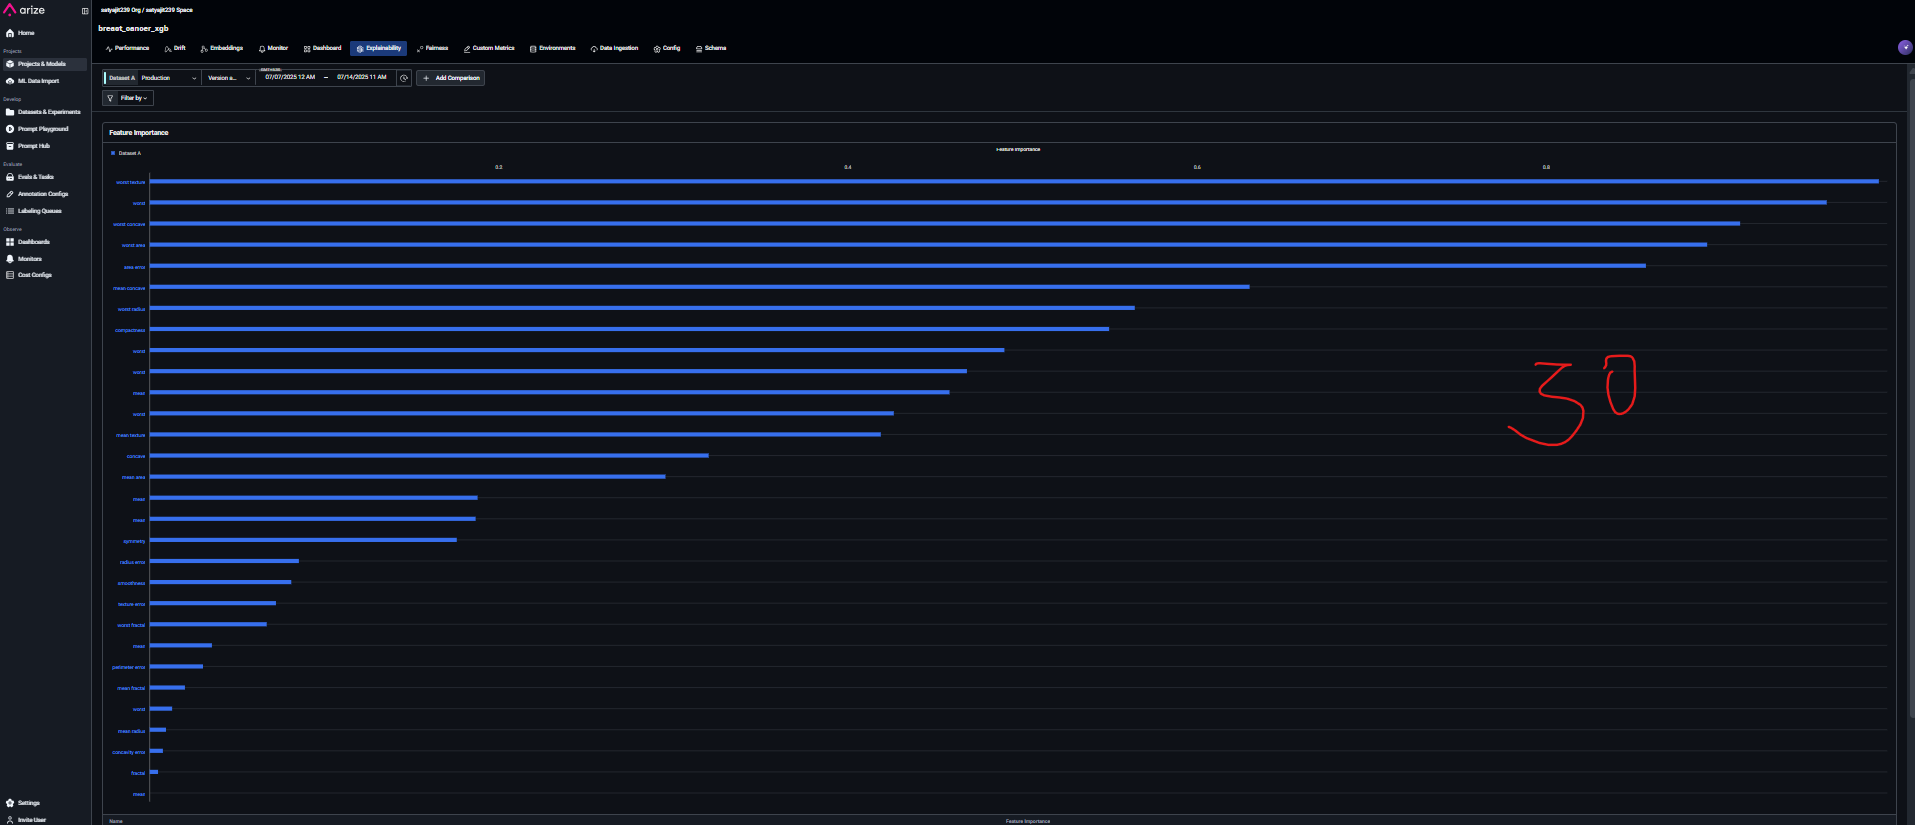

For Each feature in X the feature importance is plotted.